In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np
import pylab
from copy import deepcopy
from torchviz import make_dot

import seaborn as sns
sns.set(color_codes=True)
sns.set_style("darkgrid")

In [33]:
cifar_10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
           'ship',  'truck')


mnist_classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

batch_size = 4

In [34]:
#### Data Loading
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


## MNIST
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)

classes = mnist_classes


class_size = len(classes)


#####
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False)


In [91]:
### Helper functions
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    pylab.show()

def visualize(dataset, classes, batch_size):
    dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
    dataiter = iter(dataloader)
    images, labels = dataiter.next()
    print (labels)
    imshow(torchvision.utils.make_grid(images))
    
def flatten(items, seqtypes=(list, tuple)):
    for i, x in enumerate(items):
        while i < len(items) and isinstance(items[i], seqtypes):
            items[i:i+1] = items[i]
    return items

def hist(model):
    weights_tensors = []
    for l in model.children():
        if hasattr(l, 'weight'):
            weights_tensors.append(l.weight.data.numpy().tolist())
        else:
            print (l, "doesnt have weight")
    plt.figure()
    plt.hist(flatten(weights_tensors), bins=300, range=(0,200))
    #sns.distplot(flatten(weights_tensors),  kde=False)
    
def where(cond, x_1, x_2):
    return cond * x_1 + (1 - cond) * x_2

def prune(model, thresh):
    def kill_under_thresh(e):
        return where(abs(e) < thresh, 0, e)
        
    new_model = deepcopy(model)
    for p in new_model.parameters():
        p.data.apply_(kill_under_thresh)
    return new_model

In [9]:
#### Models

class ConvNet(nn.Module):
    conv2fc = 16 * 4 * 4
    image_size = 28 * 28 * 1    
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.fc1 = nn.Linear(self.conv2fc, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
       
        x = x.view(-1, self.conv2fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class FCNet(nn.Module):
    image_size = 28 * 28 * 1    
    def __init__(self):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(self.image_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3= nn.Linear(84, 10)
        
    def forward(self, x):
        x = x.view(-1, self.image_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [10]:
epoch_count = 3
learning_rate = 0.001
print_every = 2000
plot_every = 2000

In [13]:
### Define models
net = ConvNet()

## Loss function
criterion=nn.CrossEntropyLoss()

## Learning algorithm
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

### Training 
net.zero_grad()
for epoch in range(epoch_count + 1):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data[0]
        if i % print_every == (print_every-1):
            print ('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
       

print('Finish Training')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[1,  2000] loss: 1.066
[1,  4000] loss: 0.184
[1,  6000] loss: 0.134
[1,  8000] loss: 0.107
[1, 10000] loss: 0.093
[1, 12000] loss: 0.087
[1, 14000] loss: 0.090
[2,  2000] loss: 0.065
[2,  4000] loss: 0.058
[2,  6000] loss: 0.060
[2,  8000] loss: 0.068
[2, 10000] loss: 0.048
[2, 12000] loss: 0.053
[2, 14000] loss: 0.060
[3,  2000] loss: 0.043
[3,  4000] loss: 0.041
[3,  6000] loss: 0.044
[3,  8000] loss: 0.040
[3, 10000] loss: 0.043
[3, 12000] loss: 0.044
[3, 14000] loss: 0.048
[4,  2000] loss: 0.039
[4,  4000] loss: 0.033


KeyboardInterrupt: 

In [ ]:
## Validation 

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) doesnt have weight
Overall Accuracy 99 %
Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 98 %
Accuracy of     4 : 98 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 98 %
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) doesnt have weight
Overall Accuracy 99 %
Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 98 %
Accuracy of     4 : 98 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 98 %


0.9901

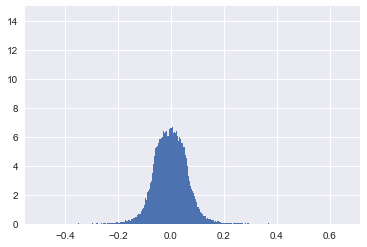

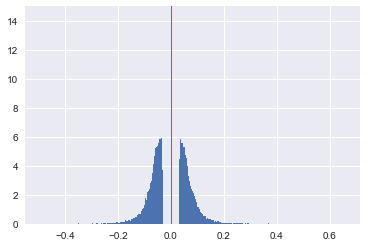

In [113]:
def test_model(model):
    correct = 0
    total = 0
    class_correct = list(0. for i in range(class_size))
    class_total = list(0. for i in range(class_size))

    for data in testloader:
        images, labels = data
        outputs = model(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze().numpy()

        total += labels.size(0)
        correct += (predicted == labels).sum()

        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i]
            class_total[label] += 1

    print('Overall Accuracy %2d %%' % (correct.data.tolist() / total * 100))

    ### Accuracy per class
    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
    
    return (correct.data.tolist() / total)




def hist(model):
    weights_tensors = []
    for l in model.children():
        if hasattr(l, 'weight'):
            weights_tensors.append(l.weight.data.numpy().tolist())
        else:
            print (l, "doesnt have weight")
    plt.figure()
    plt.ylim(0, 15)
    plt.hist(flatten(weights_tensors), bins=300, histtype='bar',density=True)
    #sns.distplot(flatten(weights_tensors),  kde=False)

    
    
    
hist(net)
test_model(net)

net_ = prune(net, 0.03)
hist(net_)
test_model(net_)

In [114]:
print (net.conv1.weight)
print (model_.conv1.weight)

Parameter containing:
tensor([[[[-0.0659, -0.1311,  0.0178, -0.0802, -0.0338],
          [ 0.3688,  0.3736,  0.3834,  0.4991,  0.4404],
          [-0.2277, -0.0045,  0.2133,  0.0819,  0.1473],
          [-0.1990, -0.3077, -0.2124, -0.1919,  0.0792],
          [-0.2583, -0.3529, -0.3968, -0.1310,  0.0896]]],


        [[[ 0.0033,  0.4497,  0.2772,  0.0245, -0.0542],
          [-0.1400,  0.4111,  0.3718, -0.2375, -0.4153],
          [-0.0905,  0.4734,  0.3587, -0.1099, -0.2982],
          [-0.0950,  0.4995,  0.2873, -0.1416, -0.2237],
          [ 0.2130,  0.0772,  0.2737,  0.0384, -0.1559]]],


        [[[-0.2499,  0.0884,  0.1373,  0.2966, -0.0713],
          [-0.3497, -0.2521,  0.2373,  0.2294,  0.1551],
          [-0.1386, -0.2046,  0.0912,  0.1057,  0.2725],
          [-0.3747, -0.1352,  0.4148,  0.1289, -0.0001],
          [-0.3496, -0.2362,  0.4538,  0.0284, -0.0414]]],


        [[[ 0.3468, -0.1720, -0.3964, -0.4680, -0.2258],
          [ 0.3574,  0.4843, -0.2604, -0.2201, -0.3838

In [116]:
net

ConvNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

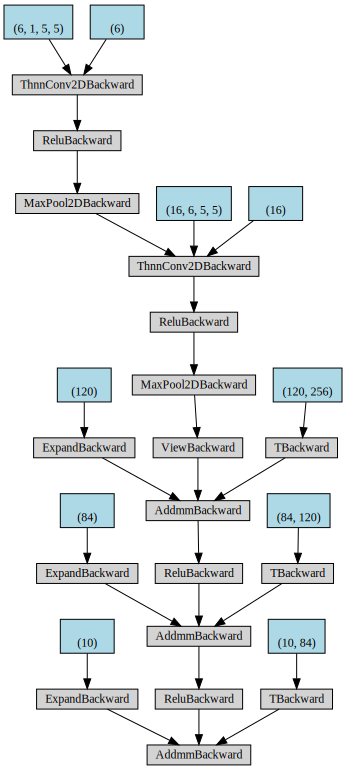

In [115]:
from torchviz import make_dot

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
for i, data in enumerate(trainloader):
    images, label = data
    break

m = ConvNet()
y = m(Variable(images))
make_dot(y)

In [ ]:
# CIFAR 100